### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

## Check for GPU

In [1]:
import tensorflow as tf
print(tf.__version__)

pd = tf.config.experimental.list_physical_devices()
for i in pd:
    print(i)
print('------------------------------------------------------------------------------------------')


print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x000001AA24AFEC10>

print(tf.test.gpu_device_name())
# /device:GPU:0

#gvd = tf.config.get_visible_devices()
for j in tf.config.get_visible_devices():
    print(j)
# PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
# PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

2.3.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
------------------------------------------------------------------------------------------
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_built_with_cuda at 0x0000024D554D10D0>
/device:GPU:0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Chapter 2: Pre-processing and data exploration

ASSUMPTION: run *01_Feature_extraction_exploration.ipynb* for datasets ESC-10, BDLib2 and US8k

***

## Importe modules

In [2]:
import mimetypes
import warnings
import os
import librosa
import random
import pickle

import pandas          as pd
import numpy           as np
import seaborn         as sns
import IPython.display as ipd

from tqdm        import tqdm
from matplotlib  import pyplot as plt

In [3]:
mimetypes.init()
mimetypes.add_type('audio/ogg','.ogg')

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

In [4]:
# Globals
current_path = os.getcwd()

# For the picture names
pic_first_name = '02_PreProcessing_modeling_'

# For Librosa
FRAME_SIZE  = 1024
HOP_LENGTH  = 512
SEED        = 1000
SR          = 22050

# Values for feature extraction
threshold   = 60
frames      = 44

In [5]:
current_path

'C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\97_master'

## Loading the dataset


In [6]:
# Select the dataset

opc = 0
while str(opc) not in '123':
    print()
    print("1-) ESC-10")
    print("2-) BDLib2")
    print("3-) US8K")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:

    path        = os.path.join(current_path, "_dataset", "ESC-10")
    path_pic    = os.path.join(current_path, "ESC-10_results")
    path_models = os.path.join(current_path, "ESC-10_saved_models")
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(path_models):
        os.makedirs(path_models)
   
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'ESC-10' 
    csv_file    = 'ESC-10.csv'
    fold        = 1
    time_length = 5
    dog_set     = 'Dog bark'
    windowingNo = 9
    
    pkl_features           = 'ESC-10_features_original.pkl'
    pkl_aug_features      = 'ESC-10_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'ESC-10_features_augmented.pkl'
    
    aug_set  = True
    wind_set = True

    
if opc == 2:
    
    path        = os.path.join(current_path, "_dataset", "BDLib2")
    path_pic    = os.path.join(current_path, "BDLib2_results")
    path_models = os.path.join(current_path, "BDLib2_saved_models")
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(path_models):
        os.makedirs(path_models)

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'BDLib2' 
    csv_file    = 'BDLib2.csv'
    fold        = 'fold-1'
    time_length = 10
    dog_set     = 'dogs'
    windowingNo = 19

    pkl_features          = 'BDLib2_features_original.pkl'
    pkl_aug_features      = 'BDLib2_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'BDLib2_features_augmented.pkl'
    
    aug_set  = True
    wind_set = True

    
if opc == 3:
    
    path        = os.path.join(current_path, "_dataset", "US8K")
    path_pic    = os.path.join(current_path, "US8K_results")
    path_models = os.path.join(current_path, "US8K_saved_models")
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(path_models):
        os.makedirs(path_models)
        
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K' 
    csv_file    = 'US8K.csv'
    time_length = 4
    dog_set     = 'dog_bark'
    windowingNo = 7
    
    aug_set  = False
    wind_set = True
    
    pkl_features          = 'US8K_features_original.pkl'
    pkl_aug_features      = 'US8K_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'US8K_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large


1-) ESC-10
2-) BDLib2
3-) US8K

Select the dataset: 2


In [7]:
def get_next_file_number(folder: str):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.startswith(pic_first_name)]
    if not files:
        return 1
    else:
        numbers = [int(f.split('.')[0].split('_')[-1]) for f in files]
        return max(numbers) + 1

In [8]:
from MT_loadDataset import loadDataset

In [9]:
loadDataset = loadDataset(path)
DB          = loadDataset.db_B

print("\nClasses:\n--------------------")
print(DB["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(np.unique(DB["File_name"])))
print("Total number of AUDIO files...........: ", len(DB))
DB


CSV exported.
Check the folder :  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2

Classes:
--------------------
Class_categorical
airplane       18
alarms         18
applause       18
birds          18
dogs           18
motorcycles    18
rain           18
rivers         18
seawaves       18
thunders       18
Name: count, dtype: int64

Total number of unique files..........:  180
Total number of AUDIO files...........:  180


Fold Folder_name                      Class_OHEV Class_categorical       File_name                                                                                               Path
0    fold-1      fold-1  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]          airplane  airplane01.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane01.wav
1    fold-1      fold-1  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]          airplane  airplane02.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane02.wav
2    fold-1      fold-1  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]          airplane  airplane03.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane03.wav
3    fold-1      fold-1  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]          airplane  airplane04.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane04.wav
4    fold-1      fold-1  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]          airplane  airplane05.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane05.wav
..      ...         ...                             ...               ...             ...                                                                                                ...
175  fold-3      fold-3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]          thunders  thunders14.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders14.wav
176  fold-3      fold-3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]          thunders  thunders15.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders15.wav
177  fold-3      fold-3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]          thunders  thunders16.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders16.wav
178  fold-3      fold-3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]          thunders  thunders17.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders17.wav
179  fold-3      fold-3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]          thunders  thunders18.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders18.wav

[180 rows x 6 columns]

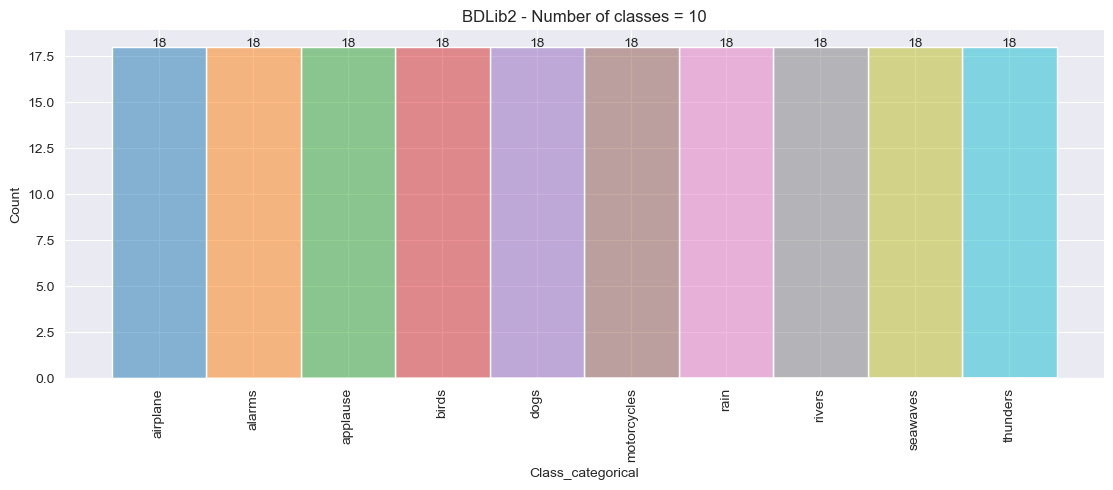

In [10]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = f'{nom_dataset} - Number of classes = ' + str(len(pd.Series(DB['Class_categorical']).unique()))
g = sns.displot(DB,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()

## Pre-processing the data (Features extraction)

### Exploratory code that lead to a class for extracting the features

Hand crafting the features into the dataframe

In [11]:
os.chdir(path)

In [12]:
pwd

'C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\97_master\\_dataset\\BDLib2'

In [13]:
# Group by the class and get one random sample of each class
k = DB.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical     
airplane           125    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
alarms             8      [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
applause           135    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
birds              79     [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
dogs               29     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
motorcycles        94     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
rain               40     [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
rivers             105    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
seawaves           110    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
thunders           177    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Name: Class_OHEV, dtype: object


{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'alarms': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'applause': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'birds': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 'dogs': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 'motorcycles': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 'rain': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 'rivers': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 'seawaves': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'thunders': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}

In [14]:
type(DB['Class_OHEV'][0][0])

int

In [15]:
encoder_dict[dog_set]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

In [16]:
DB

Fold Folder_name                      Class_OHEV Class_categorical       File_name                                                                                               Path
0    fold-1      fold-1  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]          airplane  airplane01.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane01.wav
1    fold-1      fold-1  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]          airplane  airplane02.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane02.wav
2    fold-1      fold-1  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]          airplane  airplane03.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane03.wav
3    fold-1      fold-1  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]          airplane  airplane04.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane04.wav
4    fold-1      fold-1  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]          airplane  airplane05.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane05.wav
..      ...         ...                             ...               ...             ...                                                                                                ...
175  fold-3      fold-3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]          thunders  thunders14.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders14.wav
176  fold-3      fold-3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]          thunders  thunders15.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders15.wav
177  fold-3      fold-3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]          thunders  thunders16.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders16.wav
178  fold-3      fold-3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]          thunders  thunders17.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders17.wav
179  fold-3      fold-3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]          thunders  thunders18.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders18.wav

[180 rows x 6 columns]

In [17]:
# Testing a method to parse each row and extract the defined audio feature

def feature_parser(row): 
    # Number of MFCCs and MELs
    n_mfcc = 13
    n_mels = 128
    
    # Load the audio file using "kaiser_fast" resampling method, otherwise use sr = 44100
    x, srate = librosa.load(row.Path, sr = SR)

    # Extract the features: RMS, ZCR 
    row['RMSE']      = np.mean(librosa.feature.rms(y                = x, hop_length = HOP_LENGTH, frame_length = FRAME_SIZE))
    row['ZCR']       = np.mean(librosa.feature.zero_crossing_rate(y = x, hop_length = HOP_LENGTH, frame_length = FRAME_SIZE))
    row['CENTROIDS'] = np.mean(librosa.feature.spectral_centroid(y  = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate))
    row['BANDWIDTH'] = np.mean(librosa.feature.spectral_bandwidth(y = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate))
    row['ROLLOFF']   = np.mean(librosa.feature.spectral_rolloff(y   = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate))
    
    # 128 x frames matrix
    mel              = librosa.feature.melspectrogram(y = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate, n_mels = n_mels)
    for i in range(0, n_mels):
        row[f'MEL_{i+1}'] = np.mean(mel[i])
    
    # 13 x frames matrix
    mfcc             = librosa.feature.mfcc(y = x, sr = srate, n_mfcc = n_mfcc)
    for i in range(0, n_mfcc):
        row[f'MFCC_{i+1}'] = np.mean(mfcc[i])

    # 7 x frames matrix
    spec_contrast    = librosa.feature.spectral_contrast(y = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate)
    spec_contrast_sp = np.shape(spec_contrast)
    for i in range(0, spec_contrast_sp[0]):
        row[f'CONSTRAST_{i+1}'] = np.mean(spec_contrast[i])
    
    # 12 x frames matrix
    chroma           = librosa.feature.chroma_stft(y = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate)
    chroma_sp        = np.shape(chroma)
    for i in range(0, chroma_sp[0]):
        row[f'CHROMA_{i+1}'] = np.mean(chroma[i])
    
    # 6 x frames matrix
    tonnetz          = librosa.feature.tonnetz(y = librosa.effects.harmonic(x), sr = srate)
    tonnetz_sp       = np.shape(tonnetz)
    for i in range(0, tonnetz_sp[0]):
        row[f'TONNETZ_{i+1}'] = np.mean(tonnetz[i])
    
    return row

In [18]:
print("Frame size...: ", FRAME_SIZE)
print("Hop lenght...: ", HOP_LENGTH)
print()
tqdm.pandas()

DB = DB[0:20].progress_apply(feature_parser, axis = 1)

Frame size...:  1024
Hop lenght...:  512



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


In [19]:
for col in DB.columns:
    print(col)

Fold
Folder_name
Class_OHEV
Class_categorical
File_name
Path
RMSE
ZCR
CENTROIDS
BANDWIDTH
ROLLOFF
MEL_1
MEL_2
MEL_3
MEL_4
MEL_5
MEL_6
MEL_7
MEL_8
MEL_9
MEL_10
MEL_11
MEL_12
MEL_13
MEL_14
MEL_15
MEL_16
MEL_17
MEL_18
MEL_19
MEL_20
MEL_21
MEL_22
MEL_23
MEL_24
MEL_25
MEL_26
MEL_27
MEL_28
MEL_29
MEL_30
MEL_31
MEL_32
MEL_33
MEL_34
MEL_35
MEL_36
MEL_37
MEL_38
MEL_39
MEL_40
MEL_41
MEL_42
MEL_43
MEL_44
MEL_45
MEL_46
MEL_47
MEL_48
MEL_49
MEL_50
MEL_51
MEL_52
MEL_53
MEL_54
MEL_55
MEL_56
MEL_57
MEL_58
MEL_59
MEL_60
MEL_61
MEL_62
MEL_63
MEL_64
MEL_65
MEL_66
MEL_67
MEL_68
MEL_69
MEL_70
MEL_71
MEL_72
MEL_73
MEL_74
MEL_75
MEL_76
MEL_77
MEL_78
MEL_79
MEL_80
MEL_81
MEL_82
MEL_83
MEL_84
MEL_85
MEL_86
MEL_87
MEL_88
MEL_89
MEL_90
MEL_91
MEL_92
MEL_93
MEL_94
MEL_95
MEL_96
MEL_97
MEL_98
MEL_99
MEL_100
MEL_101
MEL_102
MEL_103
MEL_104
MEL_105
MEL_106
MEL_107
MEL_108
MEL_109
MEL_110
MEL_111
MEL_112
MEL_113
MEL_114
MEL_115
MEL_116
MEL_117
MEL_118
MEL_119
MEL_120
MEL_121
MEL_122
MEL_123
MEL_124
MEL_125
MEL_126
ME

## Pre-processing the data (Features extraction)

Hand crafting the features into the dataframe

ATTENTION, setting the options *aug = True* and *windowing = True* together requires a lot of RAM.

With 64GB RAM, it's possible to use them in the datasets ESC-10 and BDLib2, but not in US8K.

In [20]:
db = pd.read_csv(os.path.join(path, csv_file))
db = db.drop('Unnamed: 0', axis=1)
db

Fold Folder_name                      Class_OHEV Class_categorical       File_name                                                                                               Path
0    fold-1      fold-1  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]          airplane  airplane01.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane01.wav
1    fold-1      fold-1  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]          airplane  airplane02.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane02.wav
2    fold-1      fold-1  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]          airplane  airplane03.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane03.wav
3    fold-1      fold-1  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]          airplane  airplane04.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane04.wav
4    fold-1      fold-1  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]          airplane  airplane05.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane05.wav
..      ...         ...                             ...               ...             ...                                                                                                ...
175  fold-3      fold-3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]          thunders  thunders14.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders14.wav
176  fold-3      fold-3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]          thunders  thunders15.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders15.wav
177  fold-3      fold-3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]          thunders  thunders16.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders16.wav
178  fold-3      fold-3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]          thunders  thunders17.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders17.wav
179  fold-3      fold-3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]          thunders  thunders18.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders18.wav

[180 rows x 6 columns]

In [21]:
type(db['Class_OHEV'][0])

str

In [22]:
dog = db[db['Class_categorical'] == dog_set]
dog

Fold Folder_name                      Class_OHEV Class_categorical   File_name                                                                                           Path
24   fold-1      fold-1  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]              dogs  dogs01.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\dogs01.wav
25   fold-1      fold-1  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]              dogs  dogs02.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\dogs02.wav
26   fold-1      fold-1  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]              dogs  dogs03.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\dogs03.wav
27   fold-1      fold-1  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]              dogs  dogs04.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\dogs04.wav
28   fold-1      fold-1  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]              dogs  dogs05.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\dogs05.wav
29   fold-1      fold-1  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]              dogs  dogs06.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\dogs06.wav
84   fold-2      fold-2  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]              dogs  dogs07.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-2\dogs07.wav
85   fold-2      fold-2  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]              dogs  dogs08.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-2\dogs08.wav
86   fold-2      fold-2  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]              dogs  dogs09.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-2\dogs09.wav
87   fold-2      fold-2  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]              dogs  dogs10.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-2\dogs10.wav
88   fold-2      fold-2  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]              dogs  dogs11.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-2\dogs11.wav
89   fold-2      fold-2  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]              dogs  dogs12.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-2\dogs12.wav
144  fold-3      fold-3  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]              dogs  dogs13.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\dogs13.wav
145  fold-3      fold-3  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]              dogs  dogs14.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\dogs14.wav
146  fold-3      fold-3  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]              dogs  dogs15.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\dogs15.wav
147  fold-3      fold-3  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]              dogs  dogs16.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\dogs16.wav
148  fold-3      fold-3  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]              dogs  dogs17.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\dogs17.wav
149  fold-3      fold-3  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]              dogs  dogs18.wav  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\dogs18.wav

In [23]:
random_idx = random.choice(dog.index.tolist())
random_sample = dog['Path'][random_idx]
print(f'Dataframe index....: {random_idx}')
print(f'Sample file name...: {random_sample}')

Dataframe index....: 87
Sample file name...: C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-2\dogs10.wav


In [24]:
ipd.Audio(random_sample, rate = SR)

### Features ORIGINAL

* *aug*       = False
* *windowing* = False

In [25]:
from MT_audioPP import audioPP
from MT_feature_extractor import feature_extractor

In [26]:
# Remove silence samples, augment and normalize (windowed) the audio files

audioPP_output = audioPP(db['Path'].values,
                         db['Class_categorical'].values, 
                         db['Class_OHEV'].values,
                         db['Fold'].values,
                         time_length = time_length,
                         threshold = threshold,
                         aug = False,
                         windowing = False,
                         frames = frames)
    
X, y_string, y_OHEV, folds  = audioPP_output.audio_windowed, audioPP_output.labels_cat_wind, audioPP_output.labels_cod_wind, audioPP_output.labels_fold_wind

100%|███████████████████████████████████████████████████████████████████████████████| 180/180 [00:01<00:00, 105.49it/s]
180it [00:05, 33.54it/s]

Shape of the audio data..................: (180, 220500)
Shape of the categorical label data......: (180,)
Shape of the one hot encoder label data..: (180,)
Shape of the fold data...................: (180,)


In [27]:
y_OHEV = [np.array(eval(s)) for s in y_OHEV]

In [28]:
db_aug = pd.DataFrame({'Audio' : X, 'Class_categorical' : y_string, 'Class_OHEV' : y_OHEV, 'Fold' : folds})
db_aug[['Fold']] = db_aug[['Fold']].astype('str')

In [29]:
print(type(db_aug['Fold'][0]))
print(type(db_aug['Class_OHEV'][0][0]))
print(type(db_aug['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [30]:
dog_aug = db_aug[db_aug['Class_categorical'] == dog_set]
dog_aug

Audio Class_categorical                      Class_OHEV    Fold
24   [0.023326298, 0.039500788, 0.042168416, 0.04847185, 0.052032616, 0.05791581, 0.058413275, 0.056565374, 0.05080685, 0...              dogs  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  fold-1
25   [-1.2092642e-05, 0.00073924987, 0.0012642795, 0.0008165023, -0.00032895769, -0.0016056062, -0.0024923757, -0.0029453...              dogs  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  fold-1
26   [0.005691266, 0.008032814, 0.0053031943, 0.005679752, 0.0060819206, 0.008389372, 0.007898692, 0.0065149534, 0.005274...              dogs  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  fold-1
27   [0.0037735905, 0.018126596, 0.030707696, 0.042715143, 0.04830569, 0.05029952, 0.047326814, 0.03694615, 0.025232194, ...              dogs  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  fold-1
28   [-0.124169216, -0.12228258, -0.048224892, 0.019326922, 0.11342672, 0.1831572, 0.27500978, 0.3114454, 0.37937367, 0.4...              dogs  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  fold-1
29   [0.05884792, 0.07850093, 0.05741816, 0.051711127, 0.031689726, 0.018851385, -0.0013828934, -0.018120095, -0.04041864...              dogs  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  fold-1
84   [5.205907e-05, 0.0003064645, 0.00023362998, 0.000192527, -0.00012498701, -0.00016934873, -0.00017898646, 2.850886e-0...              dogs  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  fold-2
85   [0.00041182837, 0.00068338064, 0.0005693368, 0.0007312335, 0.0008618616, 0.0008608147, 0.000886873, 0.0010335214, 0....              dogs  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  fold-2
86   [0.00080610067, 0.0018216099, 0.0025821559, 0.0034306042, 0.0033468786, 0.005112974, 0.007023587, 0.008325372, 0.007...              dogs  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  fold-2
87   [-0.014726007, -0.022075623, -0.019383576, -0.020482427, -0.018244233, -0.018038446, -0.015789917, -0.014777617, -0....              dogs  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  fold-2
88   [4.2887405e-07, -6.509945e-07, 1.3094395e-06, -2.1411106e-05, -5.4166652e-05, -6.8434514e-05, -9.541679e-05, -8.2797...              dogs  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  fold-2
89   [0.016404256, 0.026364218, 0.028303282, 0.03502579, 0.04091698, 0.048875, 0.05503299, 0.06128193, 0.06588091, 0.0698...              dogs  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  fold-2
144  [-0.0010606329, -0.0013594801, -0.00034688052, 7.28335e-05, -0.00053832645, -0.0013999265, -0.0014864914, -0.0020911...              dogs  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  fold-3
145  [-0.0029123724, -0.004365906, -0.003998722, -0.0041974694, -0.0039620213, -0.003930321, -0.0034650757, -0.0035987285...              dogs  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  fold-3
146  [-2.0610169e-06, -0.00013263826, -0.00025530672, -0.00034119166, -0.00032950984, -0.0003969157, -0.00044705486, -0.0...              dogs  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  fold-3
147  [0.007142023, 0.0056169857, -0.0013103532, -0.0023238426, -0.003847668, -0.005253883, -0.0058105066, -0.005131184, -...              dogs  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  fold-3
148  [-0.0004714036, -0.0011929862, -0.0016240105, -0.0016975665, -0.0011082648, -0.0003084757, 0.0005803455, 0.001361854...              dogs  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  fold-3
149  [-0.019796401, -0.027230479, -0.02049739, -0.020126112, -0.020768825, -0.019847898, -0.019882299, -0.035005324, -0.0...              dogs  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  fold-3

In [31]:
type(db_aug['Class_OHEV'][random_idx])

numpy.ndarray

In [32]:
ipd.Audio(random_sample, rate = SR)

In [33]:
librosa.get_duration(y = dog_aug['Audio'][random_idx])

10.0

In [34]:
pkl_features

'BDLib2_features_original.pkl'

In [35]:
# Extract 375 features from the audio files (long process, strongly dependent on audio duration and its agumentation)

# Check if the pkl file exists, if not, create it
if not os.path.exists(os.path.join(path_models, pkl_features)):
    Ft_extractor = feature_extractor(db_aug)
    DB_original  = Ft_extractor.DB_aug
    
    # Check for NaN values in the entire DataFrame
    has_nan_columnwise = DB_original.isna().any(axis=0)

    # Print columns with NaN values
    print("Columns with NaN values:")
    print(has_nan_columnwise[has_nan_columnwise])
    
    DB_original.fillna(0, inplace=True)

    # Save the features to a pickle file (ESC-10: ~173MB, BDLib2: ~155MB, US8K: ~3,034GB)
    DB_original.to_pickle(os.path.join(path_models, pkl_features))
    
    # Read the features from the pickle file
    DB_ori_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_features))

# If exist, read the pkl file with the features extracted
else:
    DB_ori_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_features))

In [36]:
DB_ori_from_pkl

Audio Class_categorical                      Class_OHEV    Fold      RMSE       ZCR    CENTROIDS    BANDWIDTH      ROLLOFF      MEL_1  ...  TONNETZ_5  TONNETZ_std_5  \
0    [0.08188681, 0.1348711, 0.15008344, 0.18455614, 0.18541425, 0.17385268, 0.13036996, 0.07932366, 0.015637666, -0.0407...          airplane  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  fold-1  0.171084  0.065486  1024.236461   989.624527  2079.253088   7.950548  ...  -0.002513       0.019566   
1    [0.01976405, 0.031292196, 0.03501766, 0.048891306, 0.06098544, 0.07626349, 0.08414969, 0.08607962, 0.075632036, 0.05...          airplane  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  fold-1  0.057927  0.029854   645.013265   969.704925  1229.940591   6.521725  ...  -0.006418       0.024834   
2    [-0.041798875, -0.063917994, -0.05837976, -0.06256023, -0.055258073, -0.05101881, -0.039053492, -0.027971338, -0.014...          airplane  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  fold-1  0.087988  0.042930   817.023063   997.702086  1740.567279   8.342910  ...  -0.008205       0.028049   
3    [-0.0026046187, 0.0018110918, -0.004044988, -0.018400677, -0.04110292, -0.058522597, -0.048869878, -0.041598395, -0....          airplane  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  fold-1  0.072036  0.195442  2945.973518  2518.685641  5911.039121   0.010242  ...  -0.002702       0.027731   
4    [0.0029920433, 0.0050786864, 0.0068711713, 0.011627424, 0.012284192, 0.013628962, 0.010213942, 0.00665481, 0.0080191...          airplane  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  fold-1  0.058339  0.050654  1314.319396  1875.343663  2619.981296   1.246059  ...   0.007985       0.025653   
..                                                                                                                       ...               ...                             ...     ...       ...       ...          ...          ...          ...        ...  ...        ...            ...   
175  [-0.038240783, -0.054702803, -0.046720337, -0.048071153, -0.04219207, -0.041675597, -0.037687995, -0.03788148, -0.03...          thunders  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  fold-3  0.149866  0.030885   490.138190   578.587492   852.634906   7.219920  ...   0.004724       0.019665   
176  [-0.015853848, -0.022619747, -0.020411097, -0.02190507, -0.018255692, -0.019093782, -0.018337961, -0.01841151, -0.01...          thunders  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  fold-3  0.098689  0.024666   670.725527  1285.882171   959.651428  18.995186  ...   0.010054       0.021938   
177  [2.1757325e-05, 3.4048106e-05, 2.6915688e-05, 5.4843724e-05, 6.0971826e-05, 8.278992e-05, 9.402633e-05, 0.000109863,...          thunders  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  fold-3  0.083931  0.053156   854.322022   868.765458  1596.254849   1.428895  ...   0.002999       0.020607   
178  [0.00053738384, 0.0005607162, 0.0005583146, 0.0007905933, 0.0006925161, 0.0007405731, 0.00081524736, 0.0008403693, 0...          thunders  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  fold-3  0.041032  0.035109   751.732359  1031.548051  1441.000954   2.652529  ...   0.009618       0.024643   
179  [0.0041224156, 0.0024594981, 3.1132717e-05, -0.0025945744, -0.0046762237, 0.004038036, -0.00034330762, 0.0023193345,...          thunders  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  fold-3  0.134298  0.028327  1014.205457  1884.623194  1680.713967  40.771297  ...   0.001449       0.022955   

     TONNETZ_median_5  TONNETZ_skew_5  TONNETZ_kurtosis_5  TONNETZ_6  TONNETZ_std_6  TONNETZ_median_6  TONNETZ_skew_6  TONNETZ_kurtosis_6  
0           -0.000461       -0.077123           -0.517628   0.004826       0.021489          0.003194        0.333870           -0.410127  
1           -0.005506        0.087765            0.265739  -0.000452       0.019466         -0.000496        0.100659            0.240584  
2           -0.009617        0.367308           -0.298928  -0.014833       0.021727         -0.014383        0.020060           -0.362770  
3           -0.002277        0.053111            0.220836  -0.002509       0.018855         -0.003374        0.298

In [37]:
print(type(DB_ori_from_pkl['Fold'][0]))
print(type(DB_ori_from_pkl['Class_OHEV'][0][0]))
print(type(DB_ori_from_pkl['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [38]:
print(len(DB_ori_from_pkl))

180


In [39]:
DB_ori_from_pkl.shape

(180, 379)

In [40]:
for i in DB_ori_from_pkl.columns:
    print(i)

Audio
Class_categorical
Class_OHEV
Fold
RMSE
ZCR
CENTROIDS
BANDWIDTH
ROLLOFF
MEL_1
MEL_2
MEL_3
MEL_4
MEL_5
MEL_6
MEL_7
MEL_8
MEL_9
MEL_10
MEL_11
MEL_12
MEL_13
MEL_14
MEL_15
MEL_16
MEL_17
MEL_18
MEL_19
MEL_20
MEL_21
MEL_22
MEL_23
MEL_24
MEL_25
MEL_26
MEL_27
MEL_28
MEL_29
MEL_30
MEL_31
MEL_32
MEL_33
MEL_34
MEL_35
MEL_36
MEL_37
MEL_38
MEL_39
MEL_40
MEL_41
MEL_42
MEL_43
MEL_44
MEL_45
MEL_46
MEL_47
MEL_48
MEL_49
MEL_50
MEL_51
MEL_52
MEL_53
MEL_54
MEL_55
MEL_56
MEL_57
MEL_58
MEL_59
MEL_60
MEL_61
MEL_62
MEL_63
MEL_64
MEL_65
MEL_66
MEL_67
MEL_68
MEL_69
MEL_70
MEL_71
MEL_72
MEL_73
MEL_74
MEL_75
MEL_76
MEL_77
MEL_78
MEL_79
MEL_80
MEL_81
MEL_82
MEL_83
MEL_84
MEL_85
MEL_86
MEL_87
MEL_88
MEL_89
MEL_90
MEL_91
MEL_92
MEL_93
MEL_94
MEL_95
MEL_96
MEL_97
MEL_98
MEL_99
MEL_100
MEL_101
MEL_102
MEL_103
MEL_104
MEL_105
MEL_106
MEL_107
MEL_108
MEL_109
MEL_110
MEL_111
MEL_112
MEL_113
MEL_114
MEL_115
MEL_116
MEL_117
MEL_118
MEL_119
MEL_120
MEL_121
MEL_122
MEL_123
MEL_124
MEL_125
MEL_126
MEL_127
MEL_128
MFCC_1


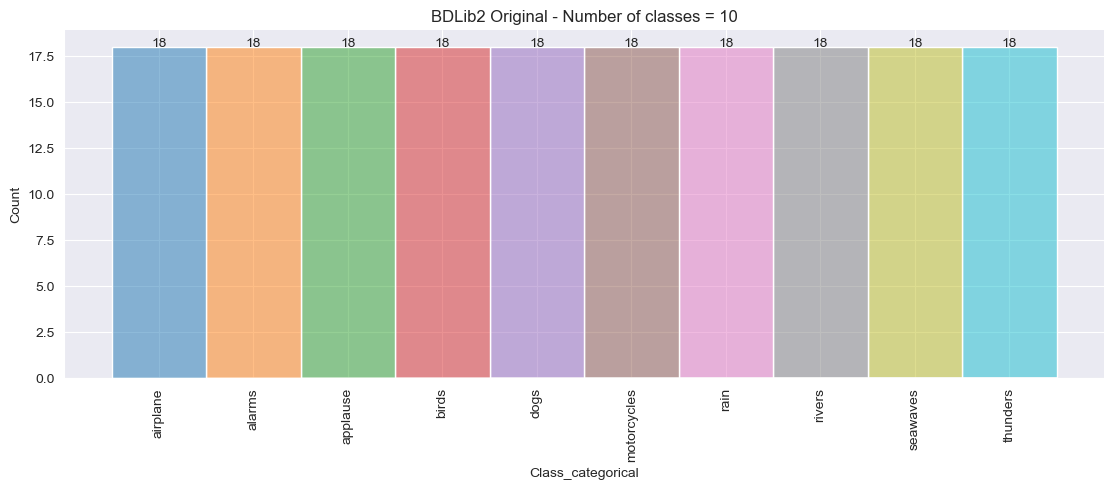

In [41]:
# Analysis of the class balancing

sns.set_style("darkgrid")
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
gTitle = nom_dataset + ' Original - Number of classes = ' + str(len(pd.Series(DB_ori_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_ori_from_pkl, x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

### Features AUGMENTED

* *aug*       = True
* *windowing* = False

Dataset will be 6x larger (original + time stretching .85 / 1.15, pitch shifting -4 / +4 semitons, and time shifting randomly)

ATTENTION: you may need to split this process in more than 2 steps due memory allocation constrains

In [42]:
# For ESC-10 and BDLib2
if opc == 1 or opc == 2:
    
    # Remove silence samples, augment and normalize (windowed) the audio files

    audioPP_output = audioPP(db['Path'].values,
                             db['Class_categorical'].values, 
                             db['Class_OHEV'].values,
                             db['Fold'].values,
                             time_length = time_length,
                             threshold = threshold,
                             aug = True,
                             windowing = False,
                             frames = frames)
    
    X, y_string, y_OHEV, folds  = audioPP_output.audio_windowed, audioPP_output.labels_cat_wind, audioPP_output.labels_cod_wind, audioPP_output.labels_fold_wind

    y_OHEV = [np.array(eval(s)) for s in y_OHEV]
    
    db_aug = pd.DataFrame({'Audio' : X, 'Class_categorical' : y_string, 'Class_OHEV' : y_OHEV, 'Fold' : folds})
    db_aug[['Fold']] = db_aug[['Fold']].astype('str')

    
# For US8K due memory allocation constraints, the process must split the files, delete the variables and join them afterwards.
else:
    
    for i in range(2):
        subset_db = db[int(i*len(db)/2):int((i+1)*len(db)/2)]

        audioPP_output = audioPP(subset_db['Path'].values,
                                 subset_db['Class_categorical'].values, 
                                 subset_db['Class_OHEV'].values,
                                 subset_db['Fold'].values,
                                 time_length = time_length,
                                 threshold = threshold,
                                 aug = True,
                                 windowing = False,
                                 frames = frames)

        X, y_string, y_OHEV, folds  = audioPP_output.audio_windowed, audioPP_output.labels_cat_wind, audioPP_output.labels_cod_wind, audioPP_output.labels_fold_wind

        del subset_db # Delete to clear memory

        y_OHEV = [np.array(eval(s)) for s in y_OHEV]

        db_aug = pd.DataFrame({'Audio' : X, 'Class_categorical' : y_string, 'Class_OHEV' : y_OHEV, 'Fold' : folds})
        db_aug[['Fold']] = db_aug[['Fold']].astype('str')

        del X, y_string, y_OHEV, folds # Delete to clear memory

        # Save db_aug as a pickle file
        with open(os.path.join(path_models, f'db_aug_{i+1}.pkl'), 'wb') as f:
            pickle.dump(db_aug, f)

        del db_aug  # Delete db_aug to clear memory

    # Read and join both db_aug_1 and db_aug_2 into db_aug
    with open(os.path.join(path_models,'db_aug_1.pkl'), 'rb') as f:
        db_aug_1 = pickle.load(f)

    with open(os.path.join(path_models,'db_aug_2.pkl'), 'rb') as f:
        db_aug_2 = pickle.load(f)

    db_aug = pd.concat([db_aug_1, db_aug_2], ignore_index=True)

    del db_aug_1, db_aug_2
    os.remove(os.path.join(path_models,'db_aug_1.pkl'))
    os.remove(os.path.join(path_models,'db_aug_2.pkl'))

100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [01:17<00:00,  2.32it/s]
1080it [00:28, 37.34it/s]


Shape of the audio data..................: (1080, 220500)
Shape of the categorical label data......: (1080,)
Shape of the one hot encoder label data..: (1080,)
Shape of the fold data...................: (1080,)


In [43]:
print(type(db_aug['Fold'][0]))
print(type(db_aug['Class_OHEV'][0][0]))
print(type(db_aug['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [44]:
db_aug['Audio'][random_idx*6] # 6x due augmentation to get the same sample as the original

array([-0.01472601, -0.02207562, -0.01938358, ...,  0.00967043,
        0.01293797,  0.01815795], dtype=float32)

In [45]:
ipd.Audio(random_sample, rate = SR)

In [46]:
ipd.Audio(db_aug.at[random_idx*6 + 1, 'Audio'], rate = SR) # First augmentation of the original audio

In [47]:
librosa.get_duration(y = db_aug['Audio'][random_idx*6 + 1]) # 6x due augmentation to get the same sample as the original

10.0

In [48]:
pkl_aug_features

'BDLib2_features_augmented_no_windowing.pkl'

In [49]:
# Extract 375 features from the audio files (long process, strongly dependent on audio duration and its agumentation)

# Check if the pkl file exists, if not, create it
if not os.path.exists(os.path.join(path_models, pkl_aug_features)):
    Ft_extractor = feature_extractor(db_aug)
    DB_augmented = Ft_extractor.DB_aug
    
    # Check for NaN values in the entire DataFrame
    has_nan_columnwise = DB_augmented.isna().any(axis=0)

    # Print columns with NaN values
    print("Columns with NaN values:")
    print(has_nan_columnwise[has_nan_columnwise])
    
    DB_augmented.fillna(0, inplace=True)
    
    # Save the features to a pickle file (ESC-10: ~1,213GB, BDLib2: 1,088GB, US8K: ~21,218GB)
    DB_augmented.to_pickle(os.path.join(path_models, pkl_aug_features))
    
    # Read the features from the pickle file
    DB_aug_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_features))

# If exist, read the pkl file with the features extracted
else:
    DB_aug_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_features))

In [50]:
DB_aug_from_pkl

Audio Class_categorical                      Class_OHEV    Fold      RMSE       ZCR    CENTROIDS    BANDWIDTH      ROLLOFF      MEL_1  ...  TONNETZ_5  TONNETZ_std_5  \
0     [0.08188681, 0.1348711, 0.15008344, 0.18455614, 0.18541425, 0.17385268, 0.13036996, 0.07932366, 0.015637666, -0.0407...          airplane  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  fold-1  0.171084  0.065486  1024.236461   989.624527  2079.253088   7.950548  ...  -0.002513       0.019566   
1     [0.0008365649031371843, 0.0007902029382083028, 0.0003202624053530599, -0.0007877265332074252, 0.0005094216486663931,...          airplane  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  fold-1  0.168778  0.072843  1089.288003  1022.640818  2184.645877   7.448274  ...  -0.003552       0.019067   
2     [0.08190804, 0.13502203, 0.14964262, 0.18480442, 0.18602441, 0.17493215, 0.1313063, 0.08018333, 0.016301034, -0.0399...          airplane  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  fold-1  0.117725  0.066615  1035.956029   994.313900  2094.616104   3.558578  ...  -0.006296       0.025314   
3     [0.081692986, 0.13286032, 0.14754863, 0.18129528, 0.18235432, 0.17093351, 0.12762581, 0.07619544, 0.012224363, -0.04...          airplane  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  fold-1  0.112569  0.066114  1022.837454   986.775944  2077.054803   3.097853  ...  -0.003609       0.018884   
4     [0.07598212, 0.14125115, 0.16532236, 0.19267023, 0.16932186, 0.12037183, 0.043380838, -0.029431336, -0.09211379, -0....          airplane  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  fold-1  0.119916  0.082142  1279.501431  1221.522551  2599.547235   1.940803  ...   0.007181       0.023898   
...                                                                                                                       ...               ...                             ...     ...       ...       ...          ...          ...          ...        ...  ...        ...            ...   
1075  [0.009279722347855568, 0.01698390021920204, 0.01763720065355301, 0.006145261228084564, 0.0004490441642701626, 0.0083...          thunders  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  fold-3  0.134335  0.029544  1011.801571  1882.902535  1673.169852  40.781759  ...   0.002538       0.024477   
1076  [0.0036934707, 0.002046842, -0.00035709626, -0.002943989, -0.0050576353, 0.0036802161, -0.0007292902, 0.0018817087, ...          thunders  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  fold-3  0.098744  0.029324  1001.246865  1851.062358  1631.527335  19.991053  ...  -0.003099       0.023954   
1077  [0.0040654154, 0.0022457384, -0.00041537837, -0.0029462667, -0.005005016, 0.0034745096, -0.0007470785, 0.001784253, ...          thunders  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  fold-3  0.091876  0.031110  1055.846326  1883.911805  1804.642297  25.303333  ...   0.005010       0.023717   
1078  [0.0027963016, 0.0016380685, -0.0021010456, -0.004533395, 0.0018615621, 0.00011614227, 0.0019305998, 0.0050484166, 0...          thunders  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  fold-3  0.091013  0.033122  1040.377044  1826.879465  1714.587544   7.431824  ...   0.014816       0.028888   
1079  [0.0040176073, 0.0030549683, -0.0005149855, -0.00060140697, -0.004517653, -0.005333482, 0.0018757742, 0.0014244313, ...          thunders  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  fold-3  0.091055  0.023057   799.334600  1484.238294  1324.042187  38.969021  ...  -0.003907       0.025642   

      TONNETZ_median_5  TONNETZ_skew_5  TONNETZ_kurtosis_5  TONNETZ_6  TONNETZ_std_6  TONNETZ_median_6  TONNETZ_skew_6  TONNETZ_kurtosis_6  
0            -0.000461       -0.077123           -0.517628   0.004826       0.021489          0.003194        0.333870           -0.410127  
1            -0.001189       -0.250682           -0.701549   0.004942       0.021458          0.003088        0.322753           -0.520389  
2            -0.004508       -0.091228           -0.544593  -0.000817       0.021793         -0.003592        0.254553           -0.216595  
3            -0.000282       -0.437648           -0.441136   0.003034       0.021763          0.000

In [51]:
print(type(DB_aug_from_pkl['Fold'][0]))
print(type(DB_aug_from_pkl['Class_OHEV'][0][0]))
print(type(DB_aug_from_pkl['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [52]:
print(len(DB_aug_from_pkl))

1080


In [53]:
DB_aug_from_pkl.shape

(1080, 379)

In [54]:
for i in DB_aug_from_pkl.columns:
    print(i)

Audio
Class_categorical
Class_OHEV
Fold
RMSE
ZCR
CENTROIDS
BANDWIDTH
ROLLOFF
MEL_1
MEL_2
MEL_3
MEL_4
MEL_5
MEL_6
MEL_7
MEL_8
MEL_9
MEL_10
MEL_11
MEL_12
MEL_13
MEL_14
MEL_15
MEL_16
MEL_17
MEL_18
MEL_19
MEL_20
MEL_21
MEL_22
MEL_23
MEL_24
MEL_25
MEL_26
MEL_27
MEL_28
MEL_29
MEL_30
MEL_31
MEL_32
MEL_33
MEL_34
MEL_35
MEL_36
MEL_37
MEL_38
MEL_39
MEL_40
MEL_41
MEL_42
MEL_43
MEL_44
MEL_45
MEL_46
MEL_47
MEL_48
MEL_49
MEL_50
MEL_51
MEL_52
MEL_53
MEL_54
MEL_55
MEL_56
MEL_57
MEL_58
MEL_59
MEL_60
MEL_61
MEL_62
MEL_63
MEL_64
MEL_65
MEL_66
MEL_67
MEL_68
MEL_69
MEL_70
MEL_71
MEL_72
MEL_73
MEL_74
MEL_75
MEL_76
MEL_77
MEL_78
MEL_79
MEL_80
MEL_81
MEL_82
MEL_83
MEL_84
MEL_85
MEL_86
MEL_87
MEL_88
MEL_89
MEL_90
MEL_91
MEL_92
MEL_93
MEL_94
MEL_95
MEL_96
MEL_97
MEL_98
MEL_99
MEL_100
MEL_101
MEL_102
MEL_103
MEL_104
MEL_105
MEL_106
MEL_107
MEL_108
MEL_109
MEL_110
MEL_111
MEL_112
MEL_113
MEL_114
MEL_115
MEL_116
MEL_117
MEL_118
MEL_119
MEL_120
MEL_121
MEL_122
MEL_123
MEL_124
MEL_125
MEL_126
MEL_127
MEL_128
MFCC_1


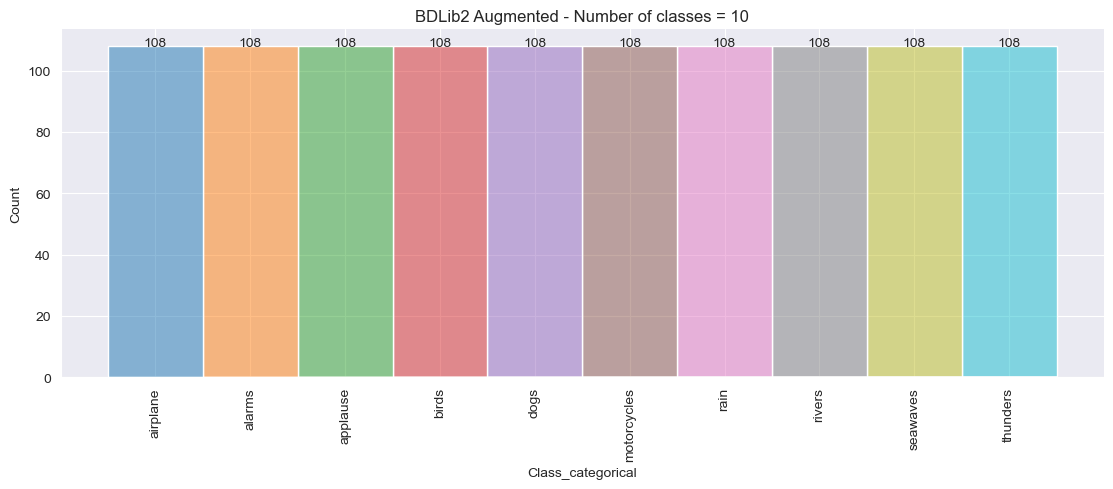

In [55]:
# Analysis of the class balancing

sns.set_style("darkgrid")
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
gTitle = nom_dataset + ' Augmented - Number of classes = ' + str(len(pd.Series(DB_aug_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_aug_from_pkl, x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

### Features AUGMENTED and WINDOWED

* *aug*       = True (not for US8K)
* *windowing* = True

Check the globals (*aug_set*, *wind_set*) in the beginning of the notebook

Initially, the dataset will be 6x larger (original + time stretching .85 / 1.15, pitch shifting -4 / +4 semitons, and time shifting randomly).

Windowing process depends on the dataset: 9 for ESC-10, 19 for BDLib2, and 7 for USK8K.

Final datasets will have:

* ESC-10 = 6 agumentations * 9  windows * 400 samples   = **21,600 samples**
* BDLib2 = 6 agumentations * 19 windows * 180 samples   = **20,520 samples**
* US8K   = 0 agumentations * 7 window   * 8,732 samples = **61,124 samples**

ATTENTION: you may need to split this process due memory allocation constrains

In [56]:
# Clear the memory
del db_aug, DB_ori_from_pkl, DB_aug_from_pkl

In [57]:
# Remove silence samples, augment and normalize (windowed) the audio files

audioPP_output = audioPP(db['Path'].values,
                         db['Class_categorical'].values, 
                         db['Class_OHEV'].values,
                         db['Fold'].values,
                         time_length = time_length,
                         threshold = threshold,
                         aug = aug_set,
                         windowing = wind_set,
                         frames = frames)
    
X, y_string, y_OHEV, folds  = audioPP_output.audio_windowed, audioPP_output.labels_cat_wind, audioPP_output.labels_cod_wind, audioPP_output.labels_fold_wind

100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [01:12<00:00,  2.50it/s]
1080it [00:29, 36.56it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1080/1080 [00:00<00:00, 24610.31it/s]


Shape of the audio data..................: (20520, 22016)
Shape of the categorical label data......: (20520,)
Shape of the one hot encoder label data..: (20520,)
Shape of the fold data...................: (20520,)


In [58]:
y_OHEV = [np.array(eval(s)) for s in y_OHEV]

In [59]:
db_aug = pd.DataFrame({'Audio' : X, 'Class_categorical' : y_string, 'Class_OHEV' : y_OHEV, 'Fold' : folds})
db_aug[['Fold']] = db_aug[['Fold']].astype('str')

In [60]:
print(type(db_aug['Fold'][0]))
print(type(db_aug['Class_OHEV'][0][0]))
print(type(db_aug['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [61]:
ipd.Audio(random_sample, rate = SR)

In [62]:
random_idx

87

In [63]:
# For ESC-10 and BDLib2
print(librosa.get_duration(y = db_aug.at[random_idx * 6 * windowingNo, 'Audio']))
ipd.Audio(db_aug.at[random_idx * 6 * windowingNo + 1, 'Audio'], rate = SR)

0.9984580498866213


In [64]:
# For US8K
print(librosa.get_duration(y = db_aug.at[random_idx * 1 * windowingNo, 'Audio']))
ipd.Audio(db_aug.at[random_idx * 1 * windowingNo, 'Audio'], rate = SR)

0.9984580498866213


In [65]:
pkl_aug_wind_features

'BDLib2_features_augmented.pkl'

In [66]:
# Extract 375 features from the audio files (long process, strongly dependent on audio duration and its agumentation)

# Check if the pkl file exists, if not, create it
if not os.path.exists(os.path.join(path_models, pkl_aug_wind_features)):
    Ft_extractor = feature_extractor(db_aug)
    DB_aug_wind  = Ft_extractor.DB_aug
    
    # Check for NaN values in the entire DataFrame
    has_nan_columnwise = DB_aug_wind.isna().any(axis=0)

    # Print columns with NaN values
    print("Columns with NaN values:")
    print(has_nan_columnwise[has_nan_columnwise])
    
    DB_aug_wind.fillna(0, inplace=True)
    
    # Save the features to a pickle file (ESC-10: ~2,232GB, BDLib2: ~2,121GB, US8K: ~5,442GB)
    DB_aug_wind.to_pickle(os.path.join(path_models, pkl_aug_wind_features)) 
    
    # Read the features from the pickle file
    DB_aug_wind_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features))

# If exist, read the pkl file with the features extracted
else:
    DB_aug_wind_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features))

100%|██████████████████████████████████████████████████████████████████████████| 20520/20520 [3:07:51<00:00,  1.82it/s]


Columns with NaN values:
CHROMA_skew_1         True
CHROMA_kurtosis_1     True
CHROMA_skew_2         True
CHROMA_kurtosis_2     True
CHROMA_skew_3         True
CHROMA_kurtosis_3     True
CHROMA_skew_4         True
CHROMA_kurtosis_4     True
CHROMA_skew_5         True
CHROMA_kurtosis_5     True
CHROMA_skew_6         True
CHROMA_kurtosis_6     True
CHROMA_skew_7         True
CHROMA_kurtosis_7     True
CHROMA_skew_8         True
CHROMA_kurtosis_8     True
CHROMA_skew_9         True
CHROMA_kurtosis_9     True
CHROMA_skew_10        True
CHROMA_kurtosis_10    True
CHROMA_skew_11        True
CHROMA_kurtosis_11    True
dtype: bool


In [67]:
DB_aug_wind_from_pkl

Audio Class_categorical                      Class_OHEV    Fold      RMSE       ZCR    CENTROIDS    BANDWIDTH      ROLLOFF      MEL_1  ...  TONNETZ_5  TONNETZ_std_5  \
0      [0.08188681, 0.1348711, 0.15008344, 0.18455614, 0.18541425, 0.17385268, 0.13036996, 0.07932366, 0.015637666, -0.0407...          airplane  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  fold-1  0.130037  0.058061   984.325245   981.163561  2015.067361   5.373944  ...   0.001468       0.011184   
1      [0.13094132, 0.10820139, 0.08821368, 0.068466306, 0.04547714, 0.021532632, 0.0026447847, -0.005522549, -0.0061496394...          airplane  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  fold-1  0.143852  0.066162  1033.056098   992.002679  2125.425027   4.293814  ...  -0.005898       0.010832   
2      [0.13508442, 0.09623987, 0.077432334, 0.08170483, 0.09066564, 0.08129832, 0.04720034, 0.0046038926, -0.020527462, -0...          airplane  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  fold-1  0.148849  0.074640  1093.306245  1024.279190  2237.740257   4.889556  ...  -0.016989       0.014591   
3      [0.05675298, 0.066010706, 0.055498227, 0.026761517, -0.005965501, -0.025278933, -0.03015221, -0.037361905, -0.065912...          airplane  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  fold-1  0.152501  0.077082  1134.819258  1058.730110  2329.990456   4.950873  ...  -0.017787       0.013385   
4      [-0.061737493, -0.061849225, -0.026519112, 0.0289907, 0.08410185, 0.12010777, 0.12399696, 0.08964014, 0.026119776, -...          airplane  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  fold-1  0.161015  0.077770  1146.715273  1060.629324  2332.926802   5.074763  ...   0.008165       0.014484   
...                                                                                                                        ...               ...                             ...     ...       ...       ...          ...          ...          ...        ...  ...        ...            ...   
20515  [0.031478796, 0.03293167, 0.03563194, 0.038413845, 0.03862507, 0.038260937, 0.03512548, 0.03133437, 0.029504607, 0.0...          thunders  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  fold-3  0.104555  0.014959   613.137613  1378.488926   704.478316  45.988369  ...   0.015561       0.023005   
20516  [0.10547611, 0.116031766, 0.12278179, 0.12800187, 0.13447388, 0.14143306, 0.15075758, 0.15834078, 0.16311401, 0.1704...          thunders  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  fold-3  0.076470  0.017933   761.868684  1560.655721  1191.177646  38.033249  ...   0.015138       0.018060   
20517  [-0.08407268, -0.07816847, -0.06976428, -0.06091842, -0.051867396, -0.046337478, -0.038424805, -0.02885189, -0.02431...          thunders  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  fold-3  0.077257  0.018399   774.331000  1568.433911  1247.702304  20.512674  ...  -0.031236       0.016911   
20518  [-0.09045054, -0.0877484, -0.08494124, -0.08406844, -0.08144917, -0.080764666, -0.078836404, -0.07132002, -0.0661413...          thunders  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  fold-3  0.070387  0.018510   838.092145  1631.340253  1520.537775  10.234927  ...  -0.019513       0.023081   
20519  [0.07220347, 0.065917194, 0.062209383, 0.061262645, 0.056036606, 0.046956547, 0.045551147, 0.044179045, 0.035008486,...          thunders  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  fold-3  0.044529  0.021573   987.780799  1780.964425  2016.535534   4.990831  ...  -0.033278       0.018856   

       TONNETZ_median_5  TONNETZ_skew_5  TONNETZ_kurtosis_5  TONNETZ_6  TONNETZ_std_6  TONNETZ_median_6  TONNETZ_skew_6  TONNETZ_kurtosis_6  
0              0.002462       -0.061253           -0.407531  -0.000974       0.022417          0.004787       -0.767807           -0.567319  
1             -0.005719       -0.435605           -0.718332   0.009660       0.025080          0.008996       -0.210640           -0.617034  
2             -0.017632        0.531756           -0.524764   0.016280       0.018064          0.010480        0.721151           -0.871713  
3             -0.021555        0.507998           -0.557673   0.005501       0.01253

In [68]:
print(type(DB_aug_wind_from_pkl['Fold'][0]))
print(type(DB_aug_wind_from_pkl['Class_OHEV'][0][0]))
print(type(DB_aug_wind_from_pkl['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [69]:
print(len(DB_aug_wind_from_pkl))

20520


In [70]:
DB_aug_wind_from_pkl.shape

(20520, 379)

In [71]:
for i in DB_aug_wind_from_pkl.columns:
    print(i)

Audio
Class_categorical
Class_OHEV
Fold
RMSE
ZCR
CENTROIDS
BANDWIDTH
ROLLOFF
MEL_1
MEL_2
MEL_3
MEL_4
MEL_5
MEL_6
MEL_7
MEL_8
MEL_9
MEL_10
MEL_11
MEL_12
MEL_13
MEL_14
MEL_15
MEL_16
MEL_17
MEL_18
MEL_19
MEL_20
MEL_21
MEL_22
MEL_23
MEL_24
MEL_25
MEL_26
MEL_27
MEL_28
MEL_29
MEL_30
MEL_31
MEL_32
MEL_33
MEL_34
MEL_35
MEL_36
MEL_37
MEL_38
MEL_39
MEL_40
MEL_41
MEL_42
MEL_43
MEL_44
MEL_45
MEL_46
MEL_47
MEL_48
MEL_49
MEL_50
MEL_51
MEL_52
MEL_53
MEL_54
MEL_55
MEL_56
MEL_57
MEL_58
MEL_59
MEL_60
MEL_61
MEL_62
MEL_63
MEL_64
MEL_65
MEL_66
MEL_67
MEL_68
MEL_69
MEL_70
MEL_71
MEL_72
MEL_73
MEL_74
MEL_75
MEL_76
MEL_77
MEL_78
MEL_79
MEL_80
MEL_81
MEL_82
MEL_83
MEL_84
MEL_85
MEL_86
MEL_87
MEL_88
MEL_89
MEL_90
MEL_91
MEL_92
MEL_93
MEL_94
MEL_95
MEL_96
MEL_97
MEL_98
MEL_99
MEL_100
MEL_101
MEL_102
MEL_103
MEL_104
MEL_105
MEL_106
MEL_107
MEL_108
MEL_109
MEL_110
MEL_111
MEL_112
MEL_113
MEL_114
MEL_115
MEL_116
MEL_117
MEL_118
MEL_119
MEL_120
MEL_121
MEL_122
MEL_123
MEL_124
MEL_125
MEL_126
MEL_127
MEL_128
MFCC_1


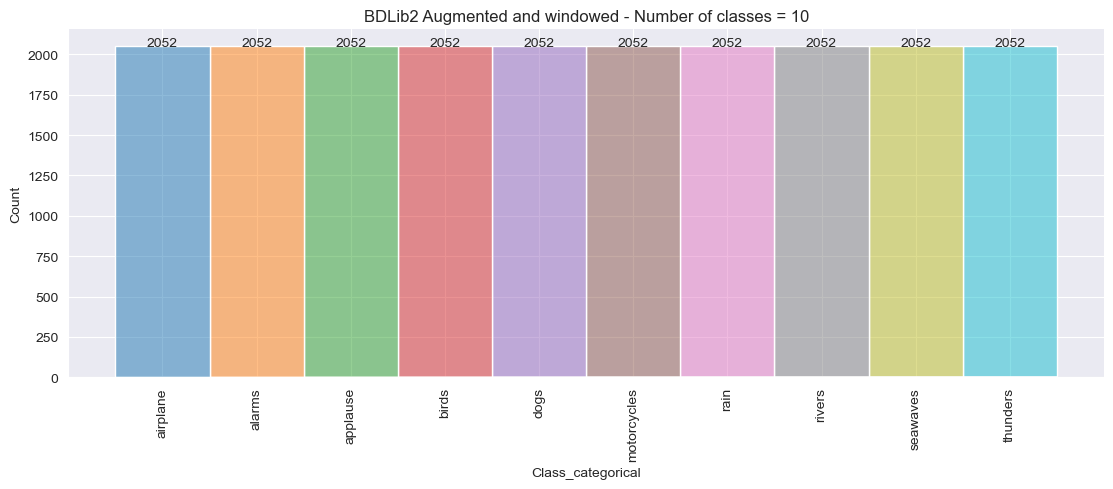

In [72]:
# Analysis of the class balancing

sns.set_style("darkgrid")
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
gTitle = nom_dataset + ' Augmented and windowed - Number of classes = ' + str(len(pd.Series(DB_aug_wind_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_aug_wind_from_pkl, x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

## Features analysis

In [73]:
DB_ori_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_features))

In [74]:
# Method to parse each row and extract the defined audio feature

def MFCC_parser(row): 
    # Number of MFCCs
    n_mfcc = 13
   
    # 13 x frames matrix
    mfcc = librosa.feature.mfcc(y = row.Audio, sr = SR, n_mfcc = n_mfcc)
    for i in range(0, n_mfcc):
        row[f'MFCC_{i+1}'] = np.array(mfcc[i])
  
    return row

In [75]:
# Method to parse each row and extract the defined audio feature

def TONNETZ_parser(row): 

    # 6 x frames matrix
    tonnetz    = librosa.feature.tonnetz(y = librosa.effects.harmonic(row.Audio), sr = SR)
    tonnetz_sp = np.shape(tonnetz)
    for i in range(0, tonnetz_sp[0]):
        row[f'TONNETZ_{i+1}'] = np.array(tonnetz[i])    

    return row

In [76]:
# Method to parse each row and extract the defined audio feature

def MEL_parser(row): 
    # Number of MELs    
    n_mels = 128

    # 128 x frames matrix
    mel = librosa.feature.melspectrogram(y = row.Audio, hop_length = HOP_LENGTH, n_fft = 2048, sr = SR, n_mels = n_mels)
    for i in range(0, n_mels):
        row[f'MEL_{i+1}'] = np.array(mel[i])

    return row

In [77]:
# Method to parse each row and extract the defined audio feature

def CONTRAST_parser(row): 

    # 7 x frames matrix
    spec_contrast    = librosa.feature.spectral_contrast(y = row.Audio, hop_length = HOP_LENGTH, n_fft = 2048, sr = SR)
    spec_contrast_sp = np.shape(spec_contrast)
    for i in range(0, spec_contrast_sp[0]):
        row[f'CONSTRAST_{i+1}'] = np.array(spec_contrast[i])

    return row

In [78]:
# Method to parse each row and extract the defined audio feature

def CHROMA_parser(row): 

    # 12 x frames matrix
    chroma    = librosa.feature.chroma_stft(y = row.Audio, hop_length = HOP_LENGTH, n_fft = 2048, sr = SR)
    chroma_sp = np.shape(chroma)
    for i in range(0, chroma_sp[0]):
        row[f'CHROMA_{i+1}'] = np.array(chroma[i])

    return row

In [79]:
MFCC_columns      = list(DB_ori_from_pkl.filter(regex='MFCC_\d', axis=1).columns)
TONNETZ_columns   = list(DB_ori_from_pkl.filter(regex='^TONNETZ_\d', axis=1).columns)
MEL_columns       = list(DB_ori_from_pkl.filter(regex='^MEL_\d', axis=1).columns)
CONSTRAST_columns = list(DB_ori_from_pkl.filter(regex='^CONSTRAST_\d', axis=1).columns)
CHROMA_columns    = list(DB_ori_from_pkl.filter(regex='^CHROMA_\d', axis=1).columns)

In [80]:
def plot_MFCC_features(feature_def, lin: int, columns: list):

    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
    
    dfSample = pd.DataFrame(DB_ori_from_pkl[lin:lin+1]).apply(feature_def, axis = 1)
    sample   = str(DB_ori_from_pkl.at[lin, 'Class_categorical'])

    f = plt.figure(figsize=(20, 12))
    sns.boxplot(dfSample.apply(lambda x: pd.Series(x.values[0])), orient = "h", order=list(reversed(columns)))
    plt.title(f'{nom_dataset} - MFCCs distribution across frames of a single audio file, class: {sample}')
    plt.savefig(os.path.join(path_pic, picture_name))

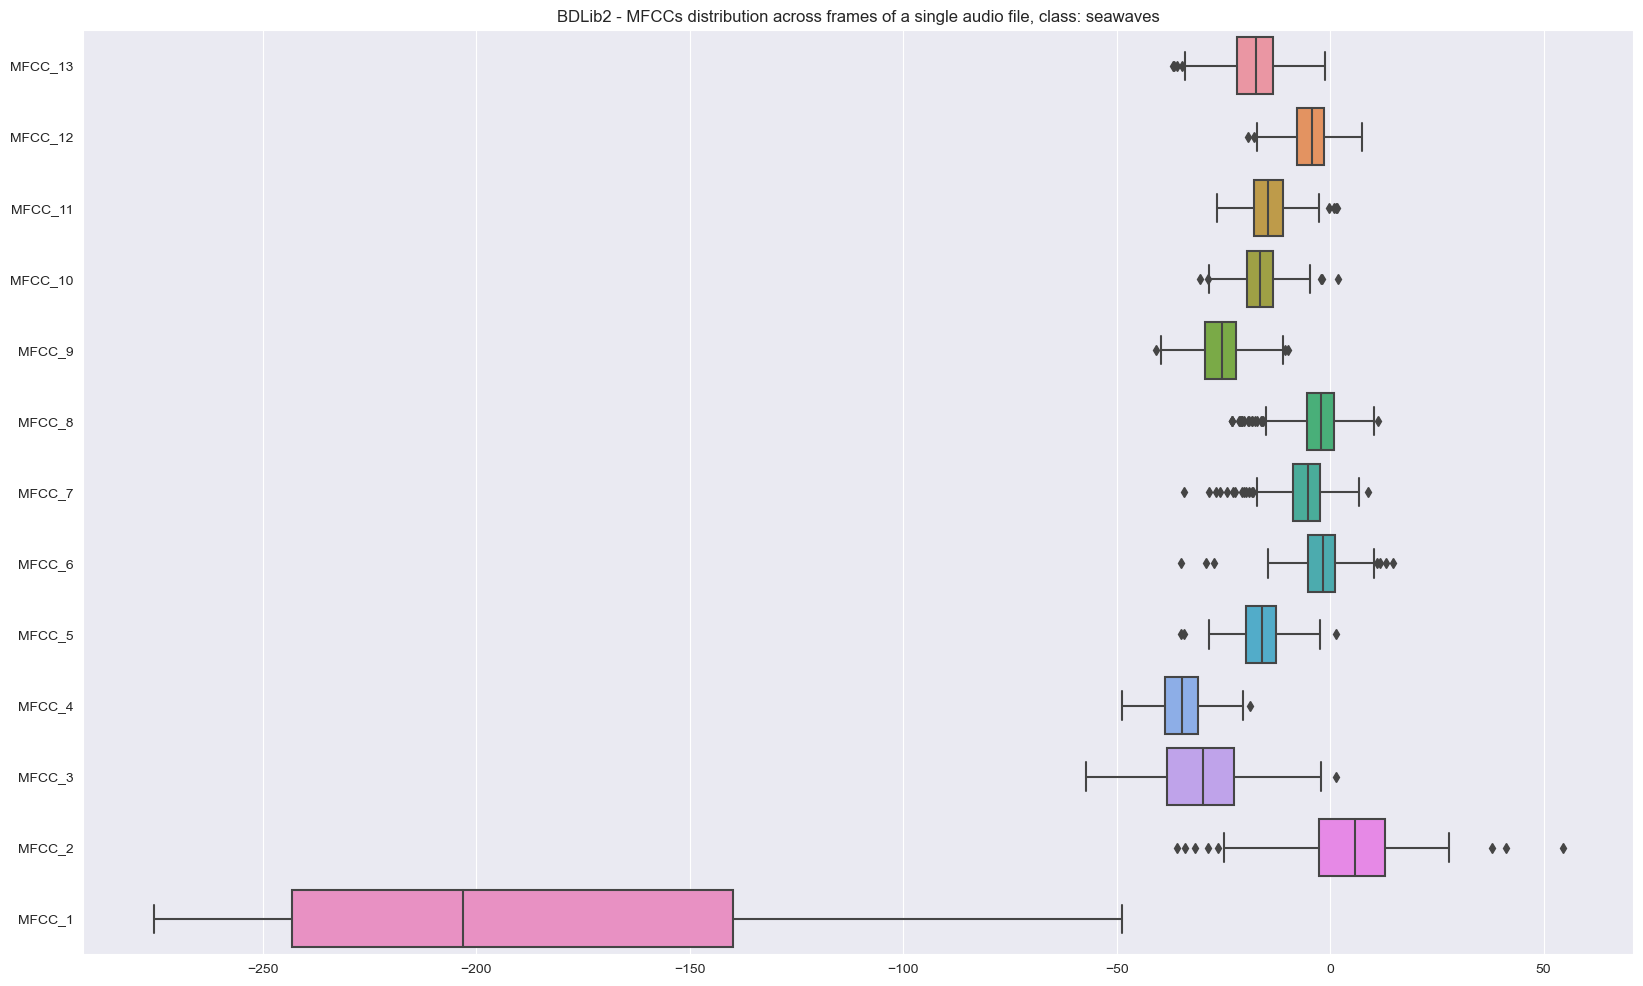

In [81]:
plot_MFCC_features(MFCC_parser, 50, MFCC_columns)

In [82]:
DB_ori_from_pkl['Class_categorical']

0      airplane
1      airplane
2      airplane
3      airplane
4      airplane
         ...   
175    thunders
176    thunders
177    thunders
178    thunders
179    thunders
Name: Class_categorical, Length: 180, dtype: object

In [83]:
dfTONNETZ   = DB_ori_from_pkl.filter(regex=r'^TONNETZ_\d', axis=1)
dfMEL       = DB_ori_from_pkl.filter(regex=r'^MEL_\d', axis=1)
dfCONSTRAST = DB_ori_from_pkl.filter(regex=r'^CONTRAST_\d', axis=1)
dfCHROMA    = DB_ori_from_pkl.filter(regex=r'^CHROMA_\d', axis=1)
dfMFCC      = DB_ori_from_pkl.filter(regex=r'^MFCC_\d', axis=1)

In [84]:
dfTONNETZ.insert(0, 'Class_categorical', DB_ori_from_pkl['Class_categorical'])
dfMEL.insert(0, 'Class_categorical', DB_ori_from_pkl['Class_categorical'])
dfCONSTRAST.insert(0, 'Class_categorical', DB_ori_from_pkl['Class_categorical'])
dfCHROMA.insert(0, 'Class_categorical', DB_ori_from_pkl['Class_categorical'])
dfMFCC.insert(0, 'Class_categorical', DB_ori_from_pkl['Class_categorical'])

In [85]:
def plot_features(db: pd.DataFrame, feature_name:str, lin:int):

    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

    sample   = str(db.at[lin, 'Class_categorical'])
    dfSample = db.drop(columns=['Class_categorical'])
    
    f = plt.figure(figsize=(20, 12))
    sns.boxplot(dfSample.apply(lambda x: pd.Series(x.values[0])), orient = "h", order=list(reversed(dfSample.columns)))
    plt.title(f'{nom_dataset} - {feature_name} distribution across frames of a single audio file, class: {sample}')
    plt.savefig(os.path.join(path_pic, picture_name))

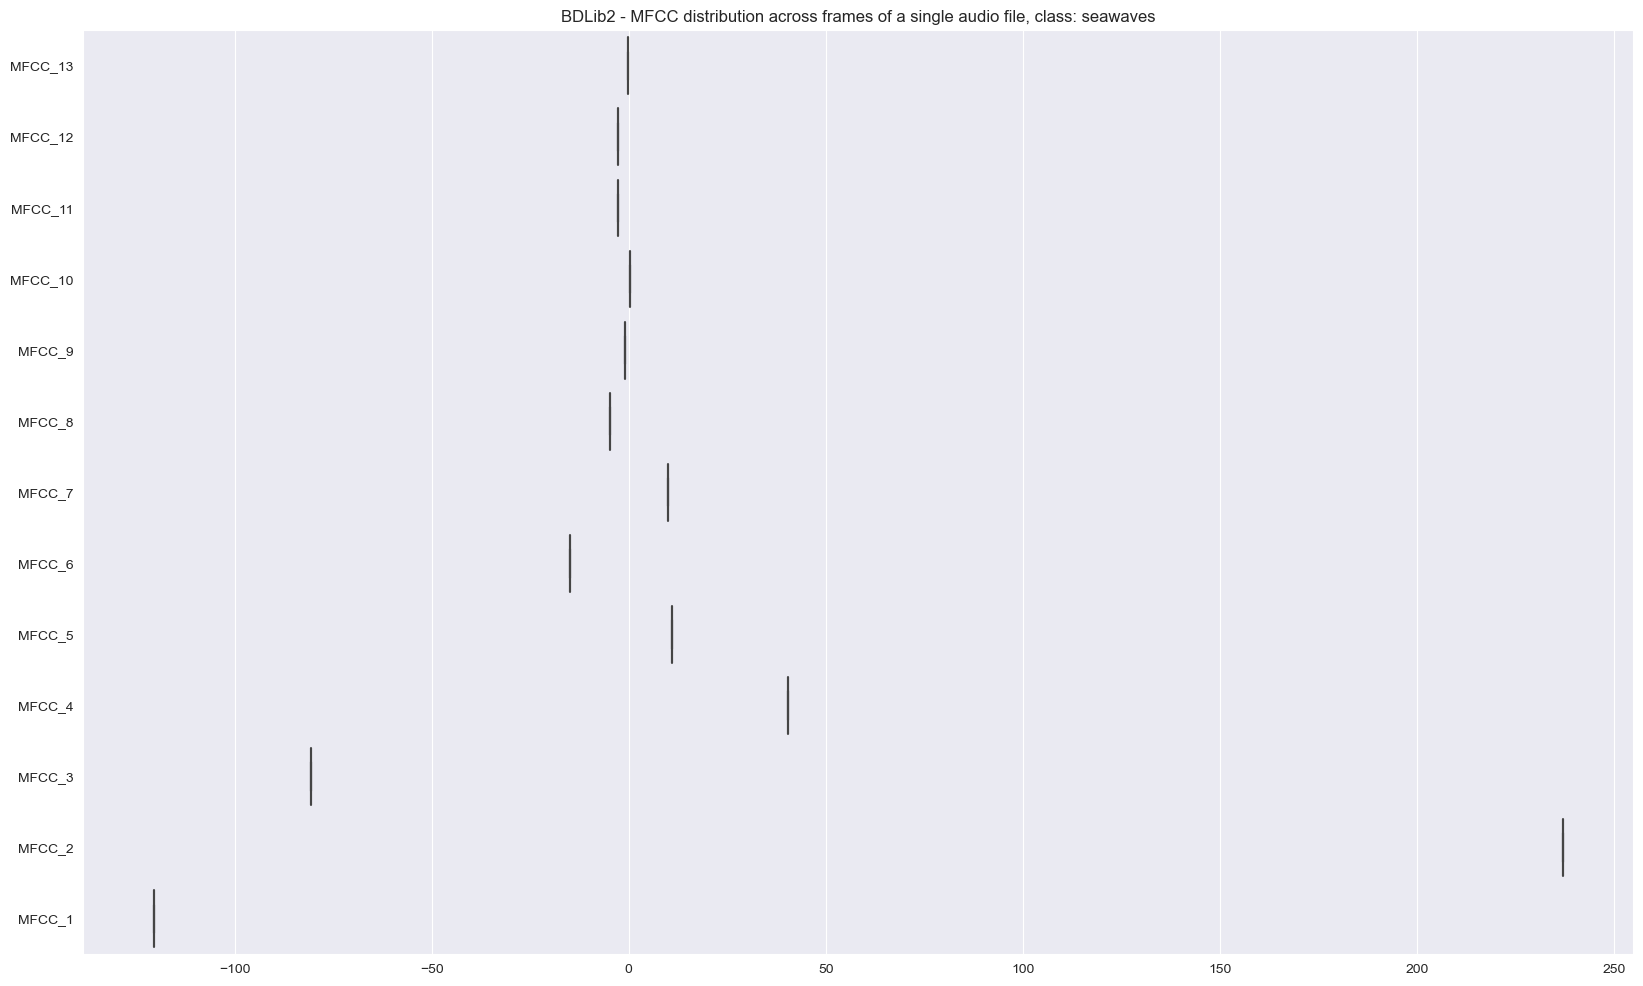

In [86]:
plot_features(dfMFCC, 'MFCC', 50)

In [87]:
audio_samples = DB_ori_from_pkl.groupby('Class_categorical')['Audio'].apply(lambda s: s.sample(1))
sampled_indices = np.array(audio_samples.index)
sampled_indices

# Convert the resulting Series to a DataFrame and reset the index
#temp_sample_df = audio_samples.reset_index()

# Convert the DataFrame to a NumPy array
#plot_samples   = temp_sample_df[['Class_categorical', 'Audio']].values
#plot_samples

array([('airplane', 65), ('alarms', 68), ('applause', 135),
       ('birds', 138), ('dogs', 148), ('motorcycles', 35), ('rain', 97),
       ('rivers', 163), ('seawaves', 50), ('thunders', 59)], dtype=object)

In [88]:
DB_ori_from_pkl.at[120,'Class_categorical']

'airplane'

In [89]:
sampled_indices.shape[0]

10

In [90]:
# Plot the MFCC features of each class sample
    
def plot_MFCC_audio_sample(data: list):
    
    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

    fig, axes = plt.subplots(int(np.ceil(np.shape(data)[0] / 2)), 2, 
                             figsize=(20, (np.ceil(data.shape[0] / 2))*6),
                            layout='constrained')
    fig.suptitle(f'{nom_dataset} - MFCC features for each class sample', fontsize = 14)
    fig.subplots_adjust(top=0.9, hspace=0.1)

    for i, ax in enumerate(axes.flatten()):
        if i < np.shape(data)[0]:
            
            dfSample = pd.DataFrame(DB_ori_from_pkl[data[i][1]:data[i][1]+1]).apply(MFCC_parser, axis = 1)
            sample   = data[i][0]

            img = sns.boxplot(dfSample.apply(lambda x: pd.Series(x.values[0])),
                              ax     = ax,
                              orient = "h", 
                              order  = list(reversed(MFCC_columns)))
            ax.set_title(f'Sample {i+1}, class {sample}') 

        else:
            ax.axis('off') 
            
    fig.tight_layout(pad = 2.0)
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.show()

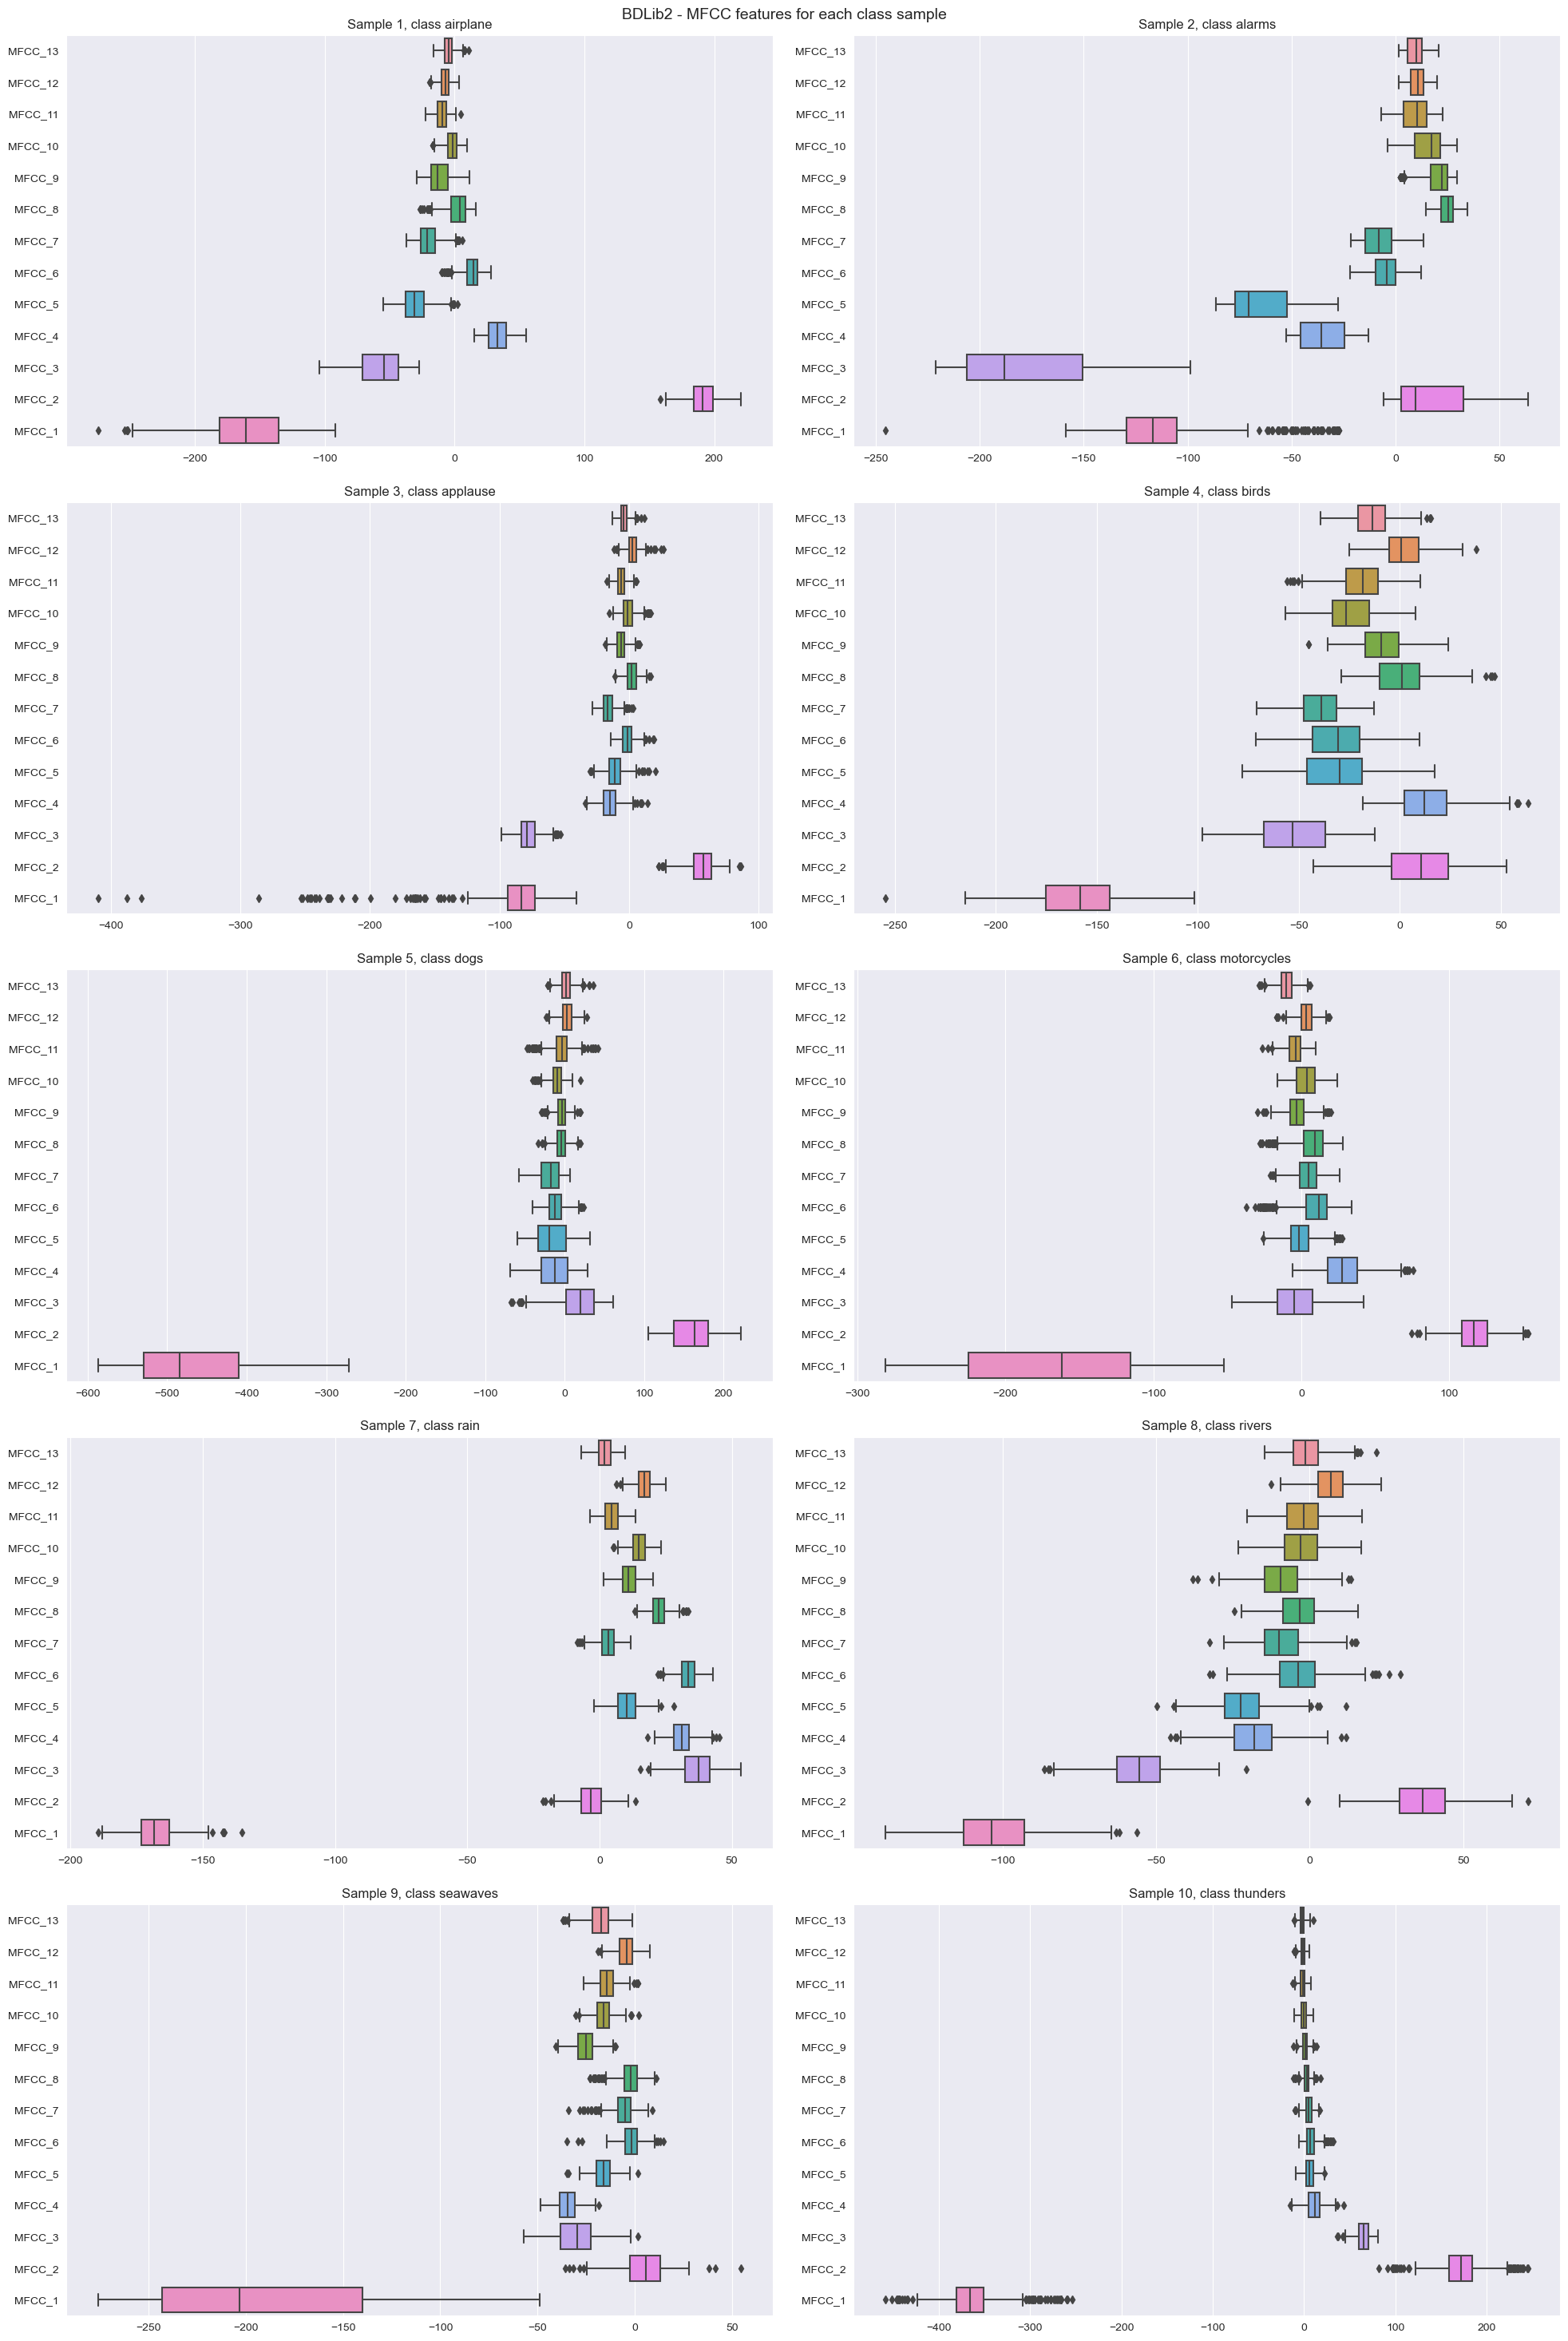

In [91]:
plot_MFCC_audio_sample(sampled_indices)

In [92]:
# Group by the class and get one random sample of each class
k = DB_ori_from_pkl.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical     
airplane           62     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
alarms             130    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
applause           76     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
birds              83     [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
dogs               27     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
motorcycles        33     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
rain               40     [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
rivers             165    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
seawaves           169    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
thunders           176    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Name: Class_OHEV, dtype: object


{'airplane': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'alarms': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'applause': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 'birds': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 'dogs': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'motorcycles': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 'rain': array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 'rivers': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 'seawaves': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 'thunders': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])}

In [93]:
nom_classes = list(encoder_dict.keys())
nom_classes

['airplane',
 'alarms',
 'applause',
 'birds',
 'dogs',
 'motorcycles',
 'rain',
 'rivers',
 'seawaves',
 'thunders']

# End of notebook